In [50]:
#reading the dataset
import pandas as pd
df= pd.read_csv('C:/Users/subka/Documents/AnacondaProjects/Phishing/dataset/phishing_site_urls.csv')
df.head() 

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [18]:
#shape
df.shape

(549346, 2)

In [52]:
#data preparation
from urllib.parse import urlparse
import tldextract

In [53]:
#map the labels good/bad to 0/1
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})
df.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,1
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,1
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,1
3,mail.printakid.com/www.online.americanexpress....,1
4,thewhiskeydregs.com/wp-content/themes/widescre...,1


In [61]:
#feature engineering

#1
df['url_length'] = df['URL'].apply(len)

#2
df['hostname_length'] = df['URL'].apply(lambda x: len(urlparse(x).netloc))

#3
df['path_length'] = df['URL'].apply(lambda x: len(urlparse(x).path))

#4
def get_fd_length(url):
    path = urlparse(url).path
    try:
        return len(path.split('/')[1])
    except IndexError:
        return 0
df['fd_length'] = df['URL'].apply(get_fd_length)


#5
df['tld_length'] = df['URL'].apply(lambda x: len(tldextract.extract(x).suffix))

#6
df['count-'] = df['URL'].apply(lambda x: x.count('-'))
df['count@'] = df['URL'].apply(lambda x: x.count('@'))
df['count?'] = df['URL'].apply(lambda x: x.count('?'))
df['count%'] = df['URL'].apply(lambda x: x.count('%'))
df['count.'] = df['URL'].apply(lambda x: x.count('.'))
df['count='] = df['URL'].apply(lambda x: x.count('='))
df['count-http'] = df['URL'].apply(lambda x: x.count('http'))
df['count-https'] = df['URL'].apply(lambda x: x.count('https'))
df['count-www'] = df['URL'].apply(lambda x: x.count('www'))



import re


df['hostname_digits'] = df['URL'].apply(lambda x: sum(c.isdigit() for c in urlparse(x).netloc))


df['hostname_is_ip'] = df['URL'].apply(lambda x: 1 if re.match(r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$", urlparse(x).netloc) else 0)

sensitive_words = ['secure', 'login', 'signin', 'bank', 'account', 'update', 'verify', 'password']
df['sensitive_word_count'] = df['URL'].apply(lambda x: sum(x.lower().count(word) for word in sensitive_words))

df['subdomain_count'] = df['URL'].apply(lambda x: len(tldextract.extract(x).subdomain.split('.')) if tldextract.extract(x).subdomain else 0)

shortening_services = ['bit.ly', 't.co', 'tinyurl.com', 'goo.gl', 'is.gd', 'cli.gs', 'tr.im']
df['uses_shortener'] = df['URL'].apply(lambda x: 1 if urlparse(x).netloc in shortening_services else 0)

In [55]:
#actual machine learning

from sklearn.ensemble import RandomForestClassifier


print("Training a Random Forest model... (This may take a moment)")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

rf_model.fit(X_train, y_train)

print("Random Forest training complete")

Training a Random Forest model... (This may take a moment)
Random Forest training complete


In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#predictions
print("Making predictions on the test set...")
predictions = model.predict(X_test)

#accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"\nModel Accuracy: {accuracy * 100:.2f}%")


# Precision, recall and F1-Score
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Legitimate', 'Phishing']))

#Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Making predictions on the test set...

Model Accuracy: 77.31%

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.82      0.26      0.39     31200
    Phishing       0.77      0.98      0.86     78670

    accuracy                           0.77    109870
   macro avg       0.79      0.62      0.63    109870
weighted avg       0.78      0.77      0.73    109870


Confusion Matrix:
[[ 8058 23142]
 [ 1787 76883]]


Generating Confusion Matrix for the Random Forest model...
Saved confusion_matrix_rf.png

Generating ROC Curve for the Random Forest model...
Saved roc_curve_rf.png


<Figure size 800x600 with 0 Axes>

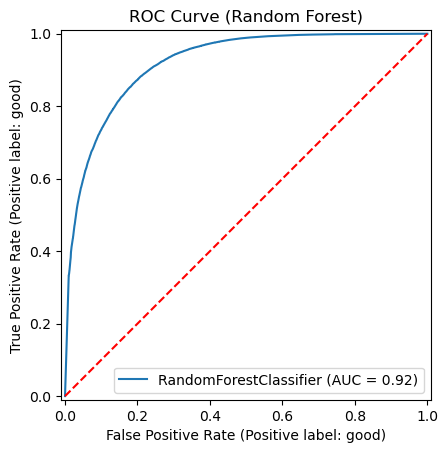

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

predictions = rf_model.predict(X_test)


print("Generating Confusion Matrix for the Random Forest model...")
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Legitimate', 'Phishing'], 
            yticklabels=['Legitimate', 'Phishing'])
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_rf.png')
print("Saved confusion_matrix_rf.png")
plt.clf()


print("\nGenerating ROC Curve for the Random Forest model...")

# Use rf_model here instead of model
RocCurveDisplay.from_estimator(rf_model, X_test, y_test) 
plt.title('ROC Curve (Random Forest)')
plt.plot([0, 1], [0, 1], 'r--')
plt.savefig('roc_curve_rf.png')
print("Saved roc_curve_rf.png")

In [78]:
import pandas as pd
import re
from urllib.parse import urlparse
import tldextract

# --- 1. Final Prediction Function with Adjustable Threshold ---
def predict_url_with_threshold(url, model, feature_columns, threshold=0.5):
    """
    Takes a URL, processes it, and returns the prediction and confidence score
    using an adjustable threshold.
    """
    # Create a DataFrame for the single URL to be processed
    test_df = pd.DataFrame([url], columns=['URL'])
    
    # Apply all features using the reusable engineering function
    # NOTE: This assumes you have the 'engineer_features' and 'get_fd_length' functions defined in your notebook
    processed_test_df = engineer_features(test_df)
    
    # Ensure the columns are in the same order as the training data
    features = processed_test_df[feature_columns]
    
    # Get the raw probabilities: [P(Legitimate), P(Phishing)]
    probabilities = model.predict_proba(features)
    
    # The probability of being phishing is the second value
    phishing_prob = probabilities[0][1] 
    
    # Determine the final label based on the adjustable threshold
    prediction = "Phishing" if phishing_prob >= threshold else "Legitimate"
    
    return prediction, phishing_prob

# --- 2. Test Suite with a Lower Threshold ---
urls_to_test = [
    "https://www.google.com",                                # Benign
    "https://www.youtube.com/watch?v=dQw4w9WgXcQ",           # Benign
    "http://secure-login-apple-support.com-update.info/",   # Malicious
    "https://amazon.co.uk.security-update.net/verify/",     # Malicious
    "tinyurl.com/bswqloj",                                  # Shortened URL
    "http://192.168.1.1/login.html"                         # IP Address URL
]

# Get the list of feature columns from your final training set
feature_columns = X.columns 

# Set a custom threshold
custom_threshold = 0.35 

print(f"--- Running Final Model Tests with Threshold = {custom_threshold:.0%} ---")

# Loop through the test URLs and print the detailed results
for url in urls_to_test:
    label, confidence = predict_url_with_threshold(url, rf_model, feature_columns, threshold=custom_threshold)
    print(f"URL:        {url}")
    print(f"Prediction: {label} (Confidence of Phishing: {confidence:.2%})\n")

--- Running Final Model Tests with Threshold = 35% ---
URL:        https://www.google.com
Prediction: Legitimate (Confidence of Phishing: 27.00%)

URL:        https://www.youtube.com/watch?v=dQw4w9WgXcQ
Prediction: Legitimate (Confidence of Phishing: 12.00%)

URL:        http://secure-login-apple-support.com-update.info/
Prediction: Phishing (Confidence of Phishing: 35.75%)

URL:        https://amazon.co.uk.security-update.net/verify/
Prediction: Legitimate (Confidence of Phishing: 9.00%)

URL:        tinyurl.com/bswqloj
Prediction: Legitimate (Confidence of Phishing: 32.08%)

URL:        http://192.168.1.1/login.html
Prediction: Legitimate (Confidence of Phishing: 6.00%)

